In [76]:
import math
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import time

DT = np.dtype('float128') # numpy precision

# SET zeta(1.2), PI, log 2, limit of slow series VALUE APPROXIMATION (~100)
Z = 5.591582441177750776536563193423143277629903241802331099473728250024897906802651077991103320801610144
PI = 3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067
L2 = 0.693147180559945309417232121458176568075500134360255254120680009493393621969694715605863326996418687
C1 = 2.10974280123689197447

constants = np.array([Z, PI, L2, C1], dtype=DT)

In [77]:
def no_transform(items: np.ndarray, max_steps=10) -> np.ndarray:
    return items

def Aitken_transform(items: np.ndarray, max_steps=10) -> np.ndarray:
    steps = min(int((len(items) - 1) / 2) - 1, max_steps)
    
    for _ in range(steps):
        acel = np.zeros(len(items) - 2, dtype=DT)

        for i in range(0, len(items) - 2):
            acel[i] = (items[i] * items[i+2] - items[i+1]**2) / \
                (items[i+2] - 2 * items[i+1] + items[i])

        items = acel

        if len(acel) < 3:
            return acel
    
    return acel
def Richardson_transform(items: np.ndarray, p=1, max_steps=10) -> np.ndarray:
    """Receive a p that represents the power of the Richardson transform"""
    steps = min(int(math.log2(len(items))) - 2, max_steps)
    
    for _ in range(steps):
        acel = np.zeros(int(len(items)/2), dtype=DT)

        for i in range(0, int(len(items)/2)):
            acel[i] = items[2*i] + (items[2*i] - items[i]) / \
                np.expm1(p * math.log(2))

        items = acel
        p = p + 1
    
    return acel

def Epsilon_transform(items: np.ndarray, max_steps=10) -> np.ndarray:
    # Initial values
    aux = np.zeros(len(items)+1, dtype=DT)
    acel = items
    
    steps = min(int(len(items) / 3) - 3, max_steps)

    for _ in range(steps):
        for i in range(0, len(aux) - 3):
            aux[i] = acel[i+1] + 1/(acel[i+1] - acel[i])
        aux = aux[:-3]

        for i in range(0, len(acel) - 3):
            acel[i] = acel[i+1] + 1/(aux[i+1] - aux[i])
        acel = acel[:-3]
    
    return acel

def G_transform(items: np.ndarray, max_steps=10) -> np.ndarray:
    # Initial values
    aux1 = np.ones(len(items) + 1, dtype=DT)
    aux2 = np.zeros(len(items), dtype=DT)

    aux2[0] = items[0]
    for i in range(1, len(items)):
        aux2[i] = items[i] - items[i-1]
    
    acel = items

    steps = min(int(len(items)/3), max_steps)

    for _ in range(steps):
        for i in range(len(aux1) - 2):
            aux1[i] = aux1[i+1] * (aux2[i+1] / aux2[i] - 1)
        aux1 = aux1[:-1]

        for i in range(len(aux2) - 2):
            aux2[i] = aux2[i+1] * (aux1[i+1] / aux1[i] - 1)
        aux2 = aux2[:-1]

        for i in range(len(acel) - 2):
            acel[i] = acel[i] - aux2[i] * (acel[i+1] - acel[i])/(aux2[i+1] - aux2[i])
        acel = acel[:-3]
    
    return acel

In [78]:
def acceleration(series, transform, error=1e-5, max_steps=5) -> np.ndarray:
    n0 = 10
    n = n0
    acel = transform(series(n0))
    i = -1  # trash

    check = np.array([acel[-1], np.log(constants[1]**2/6)], dtype=DT)
    check = np.exp(np.exp(np.sort(check)))

    while np.sum(np.array([-1, 1]) @ check) > error: # check error
        i = i + 1
        n = n0 + 2**i
        acel = transform(series(n), max_steps=max_steps)

        check = np.array([acel[-1], np.log(constants[1]**2/6)], dtype=DT)
        check = np.exp(np.sort(check))
    
    n0 = n0 + 2**(i-1)

    while (n > n0):
        acel = transform(series(int((n+n0)/2)), max_steps=max_steps)

        check = np.array([acel[-1], np.log(constants[1]**2/6)], dtype=DT)
        check = np.exp(np.sort(check))

        if np.sum(np.array([-1, 1]) @ check) > error:    # check error
            n0 = int((n+n0)/2 + 1)
        else:
            n = int((n+n0)/2)
        
    acel = transform(series(n), max_steps=max_steps)

    return n, np.exp(acel)

In [79]:
def square_series(n: int) -> np.ndarray:
    """Zeta(2) series, converges to math.pi**2 / 6"""
    series = np.zeros(n, dtype=DT)
    series[0] = 1.0

    for i in range(1, n):
        series[i] =  series[i-1] + 1/(i+1)**(2)
    
    return np.log(series)

In [80]:
acceleration(square_series, Aitken_transform, error=1e-5, max_steps=2)

(44793,
 array([1.5689838 , 1.58676345, 1.59773891, ..., 1.6449138 , 1.64491995,
        1.64492506], dtype=float128))

In [81]:
acceleration(square_series, no_transform, error=1e-4, max_steps=2)

(10000,
 array([1.        , 1.25      , 1.36111111, ..., 1.64483405, 1.64483406,
        1.64483407], dtype=float128))

1.6449340668482263082
########## 0.0001 ##########
no_transform    |   0.21967220306396484 |   1.6448340718480599  |   10000
########## 0.0001 ##########
Aitken_transform    |   0.4671297073364258 |   1.6448347982322722  |   4968
########## 0.0001 ##########
Richardson_transform    |   0.0026726722717285156 |   1.6448486698680966  |   52
########## 0.0001 ##########
Epsilon_transform    |   0.25565505027770996 |   1.6448346205284852  |   2509
########## 0.0001 ##########


/tmp/ipykernel_8054/1956262566.py:69: RuntimeWarning: divide by zero encountered in longdouble_scalars
  aux1[i] = aux1[i+1] * (aux2[i+1] / aux2[i] - 1)


G_transform    |   1.0994107723236084 |   1.6448344571273386  |   6154


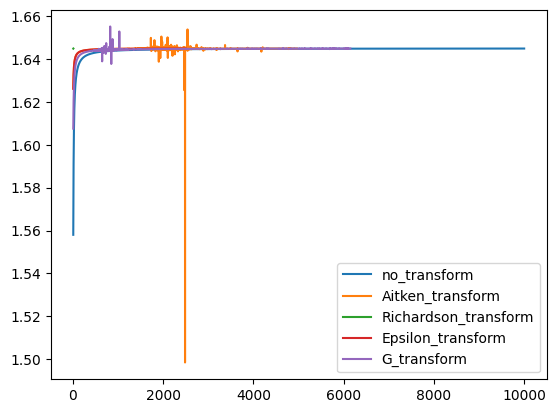

In [82]:
e = 1e-4
max_steps = 2

print(constants[1]**2/6)
for t in [no_transform, Aitken_transform, Richardson_transform, Epsilon_transform, G_transform]:
        
    if t in []:
        continue
    print(f"########## {e} ##########")
    t0 = time.time()
    n, acel = acceleration(square_series, transform=t, error=e, max_steps=max_steps)
    t1 = time.time()

    print(f"{t.__name__}    |   {t1-t0} |   {acel[-1]}  |   {n}")

    plt.plot(range(len(acel))[10:], acel[10:], label=t.__name__)
    
#true_value = constants[3]
#plt.plot(range(len(acel))[30:], [true_value for _ in range(len(acel[30:]))], label="True value")
    
plt.legend()
plt.show()
